# READ ME

A notebook using the kaggle microarray dataset : https://www.kaggle.com/crawford/gene-expression to classify two types of cancer. There are most likely microarray specific processing approaches (For example in R's Bioconductor), but for now I will consider to dataset as a numerical feature matrix.  

# IMPORTS

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
#Files
!ls

actual.csv                       gene_expression.md
data_set_ALL_AML_independent.csv output_16_0.png
data_set_ALL_AML_train.csv       output_21_0.png
gene_expression.ipynb


# PREPARE THE DATASET

In [3]:
#Eplore the files
cancer_targets = pd.read_csv("actual.csv") #targets
cancer_targets['patient'] = cancer_targets['patient'].astype('int')

print(cancer_targets["cancer"].value_counts())
print("\nNumber of samples;", cancer_targets.shape)

ALL    47
AML    25
Name: cancer, dtype: int64

Number of samples; (72, 2)


- acute myeloid leukemia (AML)
- lymphoblastic leukemia (ALL)

In [4]:
cancer_train = pd.read_csv("data_set_ALL_AML_train.csv")
cancer_test = pd.read_csv("data_set_ALL_AML_independent.csv")

print("Train shape:",cancer_train.shape)
print("Test shape:",cancer_test.shape)

#There are 72 patients according to the target dataframe, but shapes are 78 and 70 in train and test?
cancer_train.head(4)

Train shape: (7129, 78)
Test shape: (7129, 70)


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A


### MERGE TRAIN AND TEST DATASETS

For feature selection purposes, it seems better to have train and test in 1 dataframe.

In [5]:
def rename_columns(df):
    """Get's the correct patient ID for the call columns"""
    for col in df.columns:
        if "call" in col:
            loc = df.columns.get_loc(col)
            patient = df.columns[loc-1]
            df.rename(columns={col: f'Call_{patient}'}, inplace=True)
            
            
rename_columns(df=cancer_train)
rename_columns(df=cancer_test)

#check for duplicate columns
#print(cancer_test.groupby(["Gene Description"]).size().value_counts(),
#      cancer_train.groupby(["Gene Description"]).size().value_counts())

#Gene description and Gene accesion should be kept together, otherwise there will be duplicates.
cancer_train["Gene"] = cancer_train["Gene Description"] + '_' + cancer_train["Gene Accession Number"]
cancer_test["Gene"] = cancer_test["Gene Description"] + '_' +  cancer_test["Gene Accession Number"]

#Transpose the dataset and fix the columns + label train and test set with new column
cancer_train = cancer_train.T
cancer_train.columns = cancer_train.iloc[-1]
cancer_train = cancer_train[2:-1]
cancer_train['dataset'] = 'train'

cancer_test = cancer_test.T
cancer_test.columns = cancer_test.iloc[-1]
cancer_test = cancer_test[2:-1]
cancer_test['dataset'] = 'test'


df = pd.concat([cancer_train, cancer_test], axis=0,join='inner', sort=False)
df.shape

(144, 7130)

### CLEAN UP

The call columns contain: Present, Absent, and Marginal. This is a detection call by the manufacturer of the DNA Microarray used in the paper. 
(These values are related to p-values of intensity calls compared to a cutoff noise frequency it seems...). Therefore it seems best to exclude rows where all values are Absent(A) calls, i.e. untrustworthy calls. As a matter of fact it maybe better to completely zero out all A calls. We will see if this is appropriate later. This article has analysed the effect of filtering: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1409797/

In [6]:
#Genes with only A calls are not of any use:
call_rows = [row for row in df.index if "Call" in row]
conditional = df.filter(call_rows, axis=0).apply(lambda x: x == 'A', axis=1).all()
print(conditional.value_counts()) #True will be dropped.
df = df.loc[:, ~conditional]


#Next we can delete the Call rows and add the cancer labels
del df.columns.name
df.drop(call_rows, axis = 0, inplace=True)
df['patient'] = df.index
df['patient'] = df['patient'].astype('int') #Have same dtype for the columns to merge on
df.reset_index(drop=True)
#df = pd.concat([df, cancer_targets], axis=1, join='inner')

#Merge

df = pd.merge(left=df, right=cancer_targets, left_on='patient', right_on='patient')

print(df.shape)

df.head(5)

False    5328
True     1802
dtype: int64
(72, 5330)


,AFFX-BioC-5_at (endogenous control)_AFFX-BioC-5_at,hum_alu_at (miscellaneous control)_hum_alu_at,AFFX-DapX-5_at (endogenous control)_AFFX-DapX-5_at,AFFX-DapX-M_at (endogenous control)_AFFX-DapX-M_at,AFFX-LysX-5_at (endogenous control)_AFFX-LysX-5_at,AFFX-HUMISGF3A/M97935_MA_at (endogenous control)_AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at (endogenous control)_AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at (endogenous control)_AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at (endogenous control)_AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at (endogenous control)_AFFX-HUMRGE/M10098_M_at,...,Breast epithelial antigen BA46 mRNA_U58516_at,TUBULIN ALPHA-4 CHAIN_X06956_at,PTGER3 Prostaglandin E receptor 3 (subtype EP3) {alternative products}_X83863_at,HMG2 High-mobility group (nonhistone chromosomal) protein 2_Z17240_at,RB1 Retinoblastoma 1 (including osteosarcoma)_L49218_f_at,GB DEF = Glycophorin Sta (type A) exons 3 and 4; partial_M71243_f_at,GB DEF = mRNA (clone 1A7)_Z78285_f_at,dataset,patient,cancer
0,88,15091,7,311,21,-13,215,797,14538,9738,...,511,389,793,329,36,191,-37,train,1,ALL
1,283,11038,37,134,-21,-219,116,433,615,115,...,837,442,782,295,11,76,-14,train,2,ALL
2,309,16692,183,378,67,104,476,1474,5669,3272,...,1199,168,1138,777,41,228,-41,train,3,ALL
3,12,15763,45,268,43,-148,155,415,4850,2293,...,835,174,627,170,-50,126,-91,train,4,ALL
4,168,18128,-28,118,-8,-55,122,483,1284,2731,...,649,504,250,314,14,56,-25,train,5,ALL


In [7]:
#Assign train and test sets
train = df[df['dataset'] == 'train'].iloc[:,1:-3]
train_target = df[df['dataset'] == 'train'].iloc[:,-1]
test = df[df['dataset'] == 'test'].iloc[:,1:-3]
test_target = df[df['dataset'] == 'test'].iloc[:,-1]

print(train.shape, train_target.shape)
print(test.shape, test_target.shape)

(38, 5326) (38,)
(34, 5326) (34,)


# PREPROCESSING AND FEATURE SELECTION

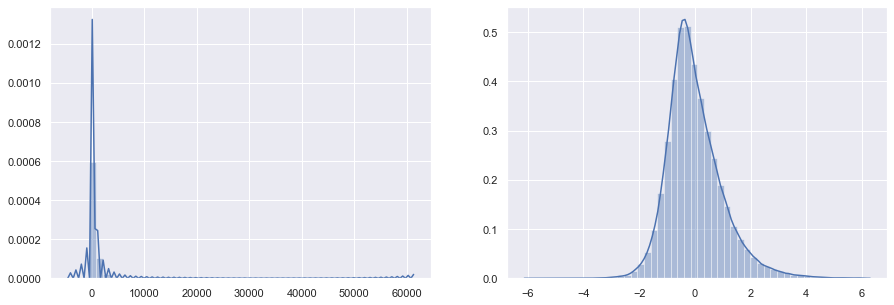

In [8]:
#Scaling
#Initialize a scaler later to be used on test set as well.
scaler = StandardScaler().fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

#Awkward distribution!
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.distplot(np.concatenate(train.values), ax=ax[0])
sns.distplot(np.concatenate(train_scaled.values), ax=ax[1])
plt.tight_layout
plt.show()

Original Shape: (38, 5326)


/Users/mattijsbeirinckx/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Features after selection using Logistic Regression: (38, 1266)
Features after selection using ExtraTreesClassifier: (38, 793)


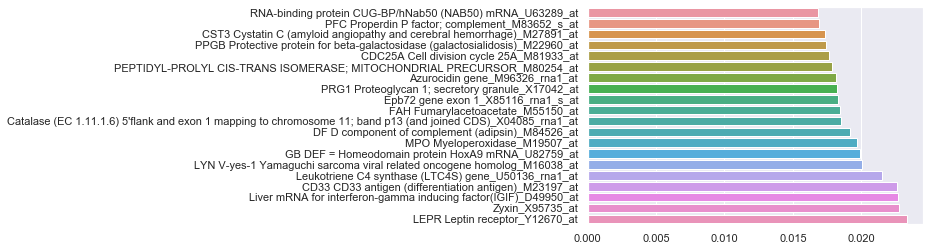

In [17]:
#Feature selection using SelectFromModel and Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

print("Original Shape:", train_scaled.shape)
logistic_regression = LogisticRegression(penalty="l1", solver='saga').fit(train_scaled, train_target) #l1 for sparsity
log_coefficients = logistic_regression.coef_
model = SelectFromModel(logistic_regression, prefit=True)
train_scaled_logreg = model.transform(train_scaled)
print("Features after selection using Logistic Regression:", train_scaled_logreg.shape) 


#Alternatively
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(train_scaled, train_target) 
model = SelectFromModel(clf, prefit=True)
train_scaled_tree = model.transform(train_scaled)
test_scaled_tree = model.transform(test_scaled)
print("Features after selection using ExtraTreesClassifier:", train_scaled_tree.shape)



#Absolute values for coefficients in Logistic Regression "=~importance"
log_coefficients_abs = abs(log_coefficients)
log_coefficients_abs_sort = np.sort(log_coefficients_abs).flatten()
sortedidx = log_coefficients_abs.argsort()
log_labels = train_scaled.columns[sortedidx].values.flatten()
sns.barplot(x=log_coefficients_abs_sort[-20:], y=log_labels[-20:]);

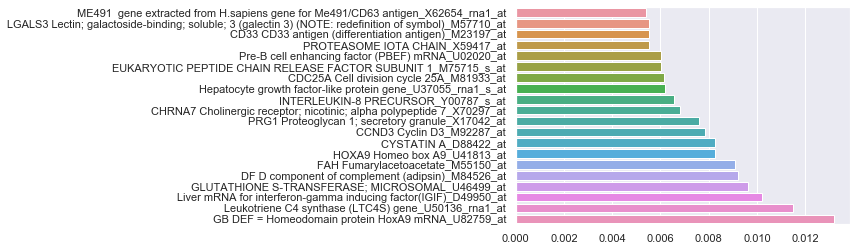

In [18]:
extratree_feature_importances_sort = np.sort(clf.feature_importances_ ).flatten()
sortedidx = clf.feature_importances_.argsort()
tree_labels = train_scaled.columns[sortedidx].values.flatten()
sns.barplot(x=extratree_feature_importances_sort[-20:], y=tree_labels[-20:]);

Using sklearn's SelectFromModel with a logistic regression and l1 norm, only 1254 genes are considered relevant to classify the two cancer types (i.e. their coefficients did not converge to zero). Using the ExtraTreesClassifier classifier on the other hand results in only 455 genes (this number is random everytime since the decision trees of the classifier select random subsets) that are necessary to classifiy the cancers.

Among the 20 highest ranked genes in both methods, 8 are the same:

    - 'CHRNA7 Cholinergic receptor; nicotinic; alpha polypeptide 7_X70297_at',
    - 'PEPTIDYL-PROLYL CIS-TRANS ISOMERASE; MITOCHONDRIAL PRECURSOR_M80254_at',
    - 'PRG1 Proteoglycan 1; secretory granule_X17042_at',
    - 'FAH Fumarylacetoacetate_M55150_at',
    - 'DF D component of complement (adipsin)_M84526_at',
    - 'Leukotriene C4 synthase (LTC4S) gene_U50136_rna1_at',
    - 'Liver mRNA for interferon-gamma inducing factor(IGIF)_D49950_at',
    - 'LEPR Leptin receptor_Y12670_at'

# PRINCIPAL COMPONENT ANALYSIS
### Using the dataset retrieved from the feature selection method using the ExtraTreesClassifier

In [22]:
#Let's do a pca first 
pca = PCA(n_components=3)
pca.fit_transform(train_scaled_tree)
print(pca.explained_variance_ratio_) # Small variance explained

PCA_df = pd.DataFrame(data = pca.fit_transform(train_scaled_tree), 
                           columns = ['pc1', 'pc2', 'pc3'])

[0.19592345 0.13509737 0.08134541]


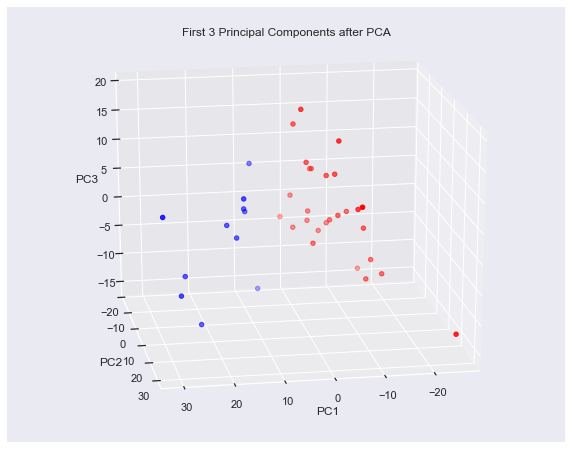

In [23]:
PCA_df = pd.concat([PCA_df, train_target], axis = 1)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
colors = {'ALL':'red', 'AML':'blue'}
ax.scatter(PCA_df.pc1, PCA_df.pc2, PCA_df.pc3, 
           c=train_target.apply(lambda x: colors[x]))
plt.title('First 3 Principal Components after PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(20, 80)
plt.tight_layout
plt.show()

The above plot shows relatively  separation of the two cancer types along the first 3 components as defined by PCA using. Even using only PC1 and PC2 would already separate them.

# MODEL SELECTION

In [24]:
# Model Selection

classifiers = [LogisticRegression(),
               KNeighborsClassifier(n_neighbors=5),
               SVC(),
               RandomForestClassifier(n_estimators=100, min_samples_leaf=4),
               MLPClassifier(hidden_layer_sizes=250),
               GaussianNB()
              ]
names = ['Logistic Regression',
         'K Nearest Neighbours', 
         'Support Vector Machine', 
         'Random Forest', 
         'Multi Layer Perceptron', 
         'Gaussian Naive Bayes'
        ]

for name, classifier in zip(names,classifiers):
    
    #fit
    clf = classifier.fit(train_scaled_tree, train_target)
    
    #predictions on test set
    pred_targets = clf.predict(test_scaled_tree)
    
    #print results
    print(f'\nResults for {name}:\n')
    print(classification_report(test_target,pred_targets))
    print(confusion_matrix(test_target,pred_targets))


Results for Logistic Regression:

              precision    recall  f1-score   support

         ALL       0.87      1.00      0.93        20
         AML       1.00      0.79      0.88        14

    accuracy                           0.91        34
   macro avg       0.93      0.89      0.91        34
weighted avg       0.92      0.91      0.91        34

[[20  0]
 [ 3 11]]

Results for K Nearest Neighbours:

              precision    recall  f1-score   support

         ALL       0.71      1.00      0.83        20
         AML       1.00      0.43      0.60        14

    accuracy                           0.76        34
   macro avg       0.86      0.71      0.72        34
weighted avg       0.83      0.76      0.74        34

[[20  0]
 [ 8  6]]

Results for Support Vector Machine:

              precision    recall  f1-score   support

         ALL       0.74      1.00      0.85        20
         AML       1.00      0.50      0.67        14

    accuracy                       

# TO DO: AUROC/PR CURVES